In [16]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import chain
from datetime import timedelta, date, datetime, timezone
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

from secrets import *

In [17]:
# function to fix discrepancies between player names from the two sources
def playername_fix(player):
    if player == 'Nikola Jokic':
        player = 'Nikola Jokić'
    if player == 'Tomas Satoransky':
        player = 'Tomáš Satoranský'
    if player == 'Taurean Prince':
        player = 'Taurean Waller-Prince'
    if player == 'Nikola Vucevic':
        player = 'Nikola Vučević'
    if player == 'Tim Hardaway Jr.':
        player = 'Tim Hardaway'
    return(player)

In [18]:
dbname = 'cluj'
engine = create_engine('postgres://%s:%s@localhost/%s'%('docker','docker',dbname))

if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


In [19]:
league_id = 84057

### Pull injured players

In [20]:
url = 'https://fantasy.espn.com/apis/v3/games/FBA/seasons/2020/segments/0/leagues/' + str(league_id)
params={"view": "kona_player_info"}
cookies = {"swid": AUTH['swid'],
           "espn_s2": AUTH['espn_s2']}
r = requests.get(url, params=params, cookies=cookies)
data = r.json()
data.keys()

dict_keys(['players'])

In [21]:
injured_out = []
injured_dtd = []
for player in data['players']:
    for stat_item in player['player']['stats']:
        if stat_item['id'] == '002020':
            if 'injuryStatus' in player['player'].keys():
                if player['player']['injuryStatus'] == 'OUT':
                    injured_out.append(player['player']['fullName'])
                if player['player']['injuryStatus'] == 'DAY_TO_DAY':
                    injured_dtd.append(player['player']['fullName'])

### Pull matchup data

In [22]:
url = 'https://fantasy.espn.com/apis/v3/games/FBA/seasons/2020/segments/0/leagues/' + str(league_id)
params={"view": "mBoxscore"}
cookies = {"swid": AUTH['swid'],
           "espn_s2": AUTH['espn_s2']}
r = requests.get(url, params=params, cookies=cookies)
data = r.json()

In [24]:
# if matchup period hasn't started yet, then this doesn't work
# doesn't appear to be an obvious workaround 
teamId = 10
matchupPeriod = 14
matchup_end_date = '2020-1-26' # Set this manually
team_totals = {}
opponent_totals = {}
for matchup in data['schedule']:
    if ((matchup['away']['teamId'] == teamId) or (matchup['home']['teamId'] == teamId)) & (matchup['matchupPeriodId'] == matchupPeriod):
        
        if matchup['away']['teamId'] == teamId:
            team_role = 'away'
            opponent_role = 'home'
        else:
            team_role = 'home'
            opponent_role = 'away'
        
        team_players = []
        opponent_players = []
        for entry in matchup[team_role]['rosterForCurrentScoringPeriod']['entries']:
            # 12 is bench players if I also want to remove them
            # but have to make sure their lineup is set correctly
            if (entry['lineupSlotId'] != 13) & (entry['playerPoolEntry']['player']['fullName'] not in injured_out):
                team_players.append({'fullName':entry['playerPoolEntry']['player']['fullName'],
                                    'proTeamId':entry['playerPoolEntry']['player']['proTeamId']})
        for entry in matchup[opponent_role]['rosterForCurrentScoringPeriod']['entries']:
            if (entry['lineupSlotId'] != 13) & (entry['playerPoolEntry']['player']['fullName'] not in injured_out):
                opponent_players.append({'fullName':entry['playerPoolEntry']['player']['fullName'],
                                    'proTeamId':entry['playerPoolEntry']['player']['proTeamId']})

        team_totals['points'] = matchup[team_role]['cumulativeScore']['scoreByStat']['0']['score']
        team_totals['blocks'] = matchup[team_role]['cumulativeScore']['scoreByStat']['1']['score']
        team_totals['steals'] = matchup[team_role]['cumulativeScore']['scoreByStat']['2']['score']
        team_totals['assists'] = matchup[team_role]['cumulativeScore']['scoreByStat']['3']['score']
        team_totals['rebounds'] = matchup[team_role]['cumulativeScore']['scoreByStat']['6']['score']
        team_totals['threes'] = matchup[team_role]['cumulativeScore']['scoreByStat']['17']['score']
        team_totals['fga'] = matchup[team_role]['cumulativeScore']['scoreByStat']['14']['score']
        team_totals['fgm'] = matchup[team_role]['cumulativeScore']['scoreByStat']['13']['score']
        team_totals['fta'] = matchup[team_role]['cumulativeScore']['scoreByStat']['16']['score']
        team_totals['ftm'] = matchup[team_role]['cumulativeScore']['scoreByStat']['15']['score']

        opponent_totals['points'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['0']['score']
        opponent_totals['blocks'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['1']['score']
        opponent_totals['steals'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['2']['score']
        opponent_totals['assists'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['3']['score']
        opponent_totals['rebounds'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['6']['score']
        opponent_totals['threes'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['17']['score']
        opponent_totals['fga'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['14']['score']
        opponent_totals['fgm'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['13']['score']
        opponent_totals['fta'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['16']['score']
        opponent_totals['ftm'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['15']['score']
        
        break

team_players_df = pd.DataFrame(team_players)
opponent_players_df = pd.DataFrame(opponent_players)

team_players_df['fullName'] = team_players_df.fullName.apply(playername_fix)
opponent_players_df['fullName'] = opponent_players_df.fullName.apply(playername_fix)

In [25]:
team_players_df

,fullName,proTeamId
0,Buddy Hield,23
1,Giannis Antetokounmpo,15
2,Nikola Jokić,7
3,PJ Washington,30
4,Derrick Rose,8
5,Nerlens Noel,25
6,Miles Bridges,30
7,Julius Randle,18
8,Tomáš Satoranský,4
9,Markelle Fultz,19


In [26]:
opponent_players_df

,fullName,proTeamId
0,Kyrie Irving,17
1,Al Horford,20
2,Ben Simmons,20
3,Khris Middleton,15
4,LaMarcus Aldridge,24
5,Malcolm Brogdon,11
6,Aaron Gordon,19
7,Jeff Teague,1
8,Brandon Ingram,3
9,Devonte' Graham,30


### Test get n_games per day for my team

In [27]:
start_date = datetime.strftime(datetime.now(), format='%Y-%m-%d')
teamIdList = '(' + ', '.join(opponent_players_df.proTeamId.astype(str)) + ')'
sql = """
    SELECT *
    FROM espn_team_ids eid
    JOIN nba_schedule sch ON eid.scraped_name = sch.home_team OR eid.scraped_name = sch.away_team 
    WHERE espn_team_id IN {} AND sch.season_end_year = 2020 AND start_date >= '{}' AND start_date <= '{}'
""".format(teamIdList, start_date, matchup_end_date)
games = pd.read_sql(sql, engine)

teamCounts = pd.DataFrame(team_players_df.proTeamId.value_counts())
teamCounts.rename(columns={'proTeamId':'team_count'}, inplace=True)
teamCounts = teamCounts.loc[teamCounts.team_count > 1]
for i in range(len(teamCounts)):
    teamId = teamCounts.index.values[i]
    team_count = teamCounts.team_count.values[i]
    games = games.append([games.loc[games.espn_team_id == teamId]] * (team_count - 1), ignore_index=True)

In [28]:
games.start_date.value_counts(), games.start_date.value_counts().sum()

(2020-01-20    13
 2020-01-24    10
 2020-01-26     9
 2020-01-22     9
 2020-01-23     2
 2020-01-25     2
 Name: start_date, dtype: int64, 45)

In [29]:
start_date = datetime.strftime(datetime.now(), format='%Y-%m-%d')
teamIdList = '(' + ', '.join(team_players_df.proTeamId.astype(str)) + ')'
sql = """
    SELECT *
    FROM espn_team_ids eid
    JOIN nba_schedule sch ON eid.scraped_name = sch.home_team OR eid.scraped_name = sch.away_team 
    WHERE espn_team_id IN {} AND sch.season_end_year = 2020 AND start_date >= '{}' AND start_date <= '{}'
""".format(teamIdList, start_date, matchup_end_date)
games = pd.read_sql(sql, engine)

teamCounts = pd.DataFrame(team_players_df.proTeamId.value_counts())
teamCounts.rename(columns={'proTeamId':'team_count'}, inplace=True)
teamCounts = teamCounts.loc[teamCounts.team_count > 1]
for i in range(len(teamCounts)):
    teamId = teamCounts.index.values[i]
    team_count = teamCounts.team_count.values[i]
    games = games.append([games.loc[games.espn_team_id == teamId]] * (team_count - 1), ignore_index=True)

In [30]:
games.start_date.value_counts(), games.start_date.value_counts().sum()

(2020-01-20    12
 2020-01-24    10
 2020-01-22     8
 2020-01-25     6
 2020-01-26     4
 2020-01-23     3
 2020-01-21     1
 Name: start_date, dtype: int64, 44)

### Generating simulated data

In [31]:
# add season end year to boxscores and limit by that?

In [32]:
n_samples = 1000
team_samples = []
opponent_samples = []
start_date = datetime.strftime(datetime.now(), format='%Y-%m-%d')
print(start_date)

# iterate over players
for i in range(len(team_players_df)):

    player = team_players_df.iloc[i]['fullName']
    teamId = team_players_df.iloc[i]['proTeamId']
    print("Processing " + player)
    
    # get player boxscores
    sql = """
        SELECT * FROM boxscores WHERE name = '{}'
    """.format(player)
    player_boxscores = pd.read_sql(sql, engine)
    
    # get n_games for this matchup
    sql = """
        SELECT COUNT(*)
        FROM espn_team_ids eid
        JOIN nba_schedule sch ON eid.scraped_name = sch.home_team OR eid.scraped_name = sch.away_team 
        WHERE espn_team_id = {} AND sch.season_end_year = 2020 AND start_date >= '{}' AND start_date <= '{}'
    """.format(teamId, start_date, matchup_end_date)
    n_games = pd.read_sql(sql, engine).values[0][0]
    print(n_games)

    for sample in range(n_samples):
        player_samples = player_boxscores.sample(replace=False, n=n_games)
        player_samples['sample_i'] = sample
        team_samples.append(player_samples.to_dict('records'))
        
for i in range(len(opponent_players_df)):
        
    player = opponent_players_df.iloc[i]['fullName']
    teamId = opponent_players_df.iloc[i]['proTeamId']
    print("Processing " + player)
    
    # get player boxscores
    sql = """
        SELECT * FROM boxscores WHERE name = %(player)s
    """
    player_boxscores = pd.read_sql(sql, engine, params = {'player': player})
    
    # get n_games for this matchup
    sql = """
        SELECT COUNT(*)
        FROM espn_team_ids eid
        JOIN nba_schedule sch ON eid.scraped_name = sch.home_team OR eid.scraped_name = sch.away_team 
        WHERE espn_team_id = {} AND sch.season_end_year = 2020 AND start_date >= '{}' AND start_date <= '{}'
    """.format(teamId, start_date, matchup_end_date)
    n_games = pd.read_sql(sql, engine).values[0][0]
    print(n_games)

    for sample in range(n_samples):
        player_samples = player_boxscores.sample(replace=False, n=n_games)
        player_samples['sample_i'] = sample
        opponent_samples.append(player_samples.to_dict('records'))

team_samples_df = pd.DataFrame(list(chain.from_iterable(team_samples)))
opponent_samples_df = pd.DataFrame(list(chain.from_iterable(opponent_samples)))

team_totals_samples = []
opponent_total_samples = []
# iterate over samples
for sample in range(n_samples):
    
    sample_totals = {}
    team_samples_df.loc[team_samples_df['sample_i']==sample]
    sample_totals['sample_i'] = sample
    for stat in ['assists','blocks','fga','fgm','fta','ftm','points','rebounds','steals','threes']:
        sample_totals[stat] = team_totals[stat] + team_samples_df.loc[team_samples_df['sample_i']==sample][stat].sum()
    team_totals_samples.append(sample_totals)
    
    sample_totals = {}
    opponent_samples_df.loc[opponent_samples_df['sample_i']==sample]
    sample_totals['sample_i'] = sample
    for stat in ['assists','blocks','fga','fgm','fta','ftm','points','rebounds','steals','threes']:
        sample_totals[stat] = opponent_totals[stat] + opponent_samples_df.loc[opponent_samples_df['sample_i']==sample][stat].sum()
    opponent_total_samples.append(sample_totals)
    
team_totals_samples_df = pd.DataFrame(team_totals_samples)
team_totals_samples_df['ft_pct'] = team_totals_samples_df.ftm / team_totals_samples_df.fta
team_totals_samples_df['fg_pct'] = team_totals_samples_df.fgm / team_totals_samples_df.fga
opponent_total_samples_df = pd.DataFrame(opponent_total_samples)
opponent_total_samples_df['ft_pct'] = opponent_total_samples_df.ftm / opponent_total_samples_df.fta
opponent_total_samples_df['fg_pct'] = opponent_total_samples_df.fgm / opponent_total_samples_df.fga

2020-01-20
Processing Buddy Hield
3
Processing Giannis Antetokounmpo
2
Processing Nikola Jokić
4
Processing PJ Washington
2
Processing Derrick Rose
4
Processing Nerlens Noel
4
Processing Miles Bridges
2
Processing Julius Randle
4
Processing Tomáš Satoranský
4
Processing Markelle Fultz
4
Processing Taurean Waller-Prince
4
Processing Tim Hardaway
3
Processing JaVale McGee
4
Processing Kyrie Irving
4
Processing Al Horford
3
Processing Ben Simmons
3
Processing Khris Middleton
2
Processing LaMarcus Aldridge
4
Processing Malcolm Brogdon
4
Processing Aaron Gordon
4
Processing Jeff Teague
4
Processing Brandon Ingram
4
Processing Devonte' Graham
2
Processing Will Barton
4
Processing Dillon Brooks
4
Processing Ian Mahinmi
4


In [34]:
# do comparison for each cat
merged = team_totals_samples_df.merge(opponent_total_samples_df, on='sample_i')
results = {}
for stat in ['assists','blocks','fg_pct','ft_pct','points','rebounds','steals','threes']:
    results[stat] = (merged[stat+'_x'] > merged[stat+'_y']).sum()

In [35]:
results

{'assists': 11,
 'blocks': 486,
 'fg_pct': 724,
 'ft_pct': 338,
 'points': 136,
 'rebounds': 493,
 'steals': 434,
 'threes': 238}

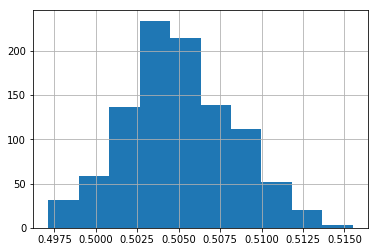

In [21]:
merged['fg_pct_x'].hist(bins=10);  

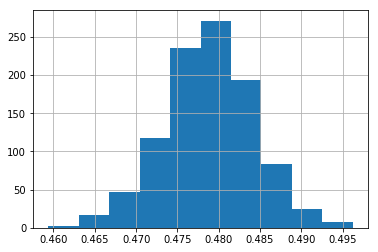

In [22]:
merged['fg_pct_y'].hist(bins=10);